In [1]:
import ROOT as root

import matplotlib.pyplot as plt

import os

import seaborn as sns

import numpy as np

import pandas as pd

from scipy.signal import find_peaks

from scipy.optimize import curve_fit

from array import array

Welcome to JupyROOT 6.24/02


In [2]:
from modules.convert_values import ConvertMiliVoltsToUnits_ScopeParameters, Convert_WaveformToMiliVolts_ScopeParameters, Convert_TimeToMicroSec

from modules.read_output_file import Get_AcquisitionParameters

from modules.find_peaks import FindPeaks_Waveform, Integral_Waveform

from modules.fit_muon_decay import A_ExpX_C, NumberBins_Sturge

from modules.delete_files import delete_root_files_in_folder

In [3]:
folder      = '../data/20220405_112457'

output_file = 'output.txt'

tree_name   = 'tree_waveforms'

delete_root_files_in_folder(folder, tree_name)

root_files  = [i for i in os.listdir(folder) if i.endswith(".root")]

In [4]:
df_output = Get_AcquisitionParameters(folder+'/'+output_file)

In [5]:
"""
Add ROOT files to TChain

    Read the entire folder and add data to the TChain
"""
#----------------------------------------------------------------------------------------------------
chain = root.TChain(tree_name)

print('\nAdding files')

for i in range( len(root_files) ): #len(root_files)
    
    file = folder+'/'+root_files[i]
    
    chain.Add(file)  

print('...   done')


Adding files
...   done


In [6]:
"""
Assign array to be filled with the .root file data
"""
#----------------------------------------------------------------------------------------------------
waveform_in_units = array('i', [0]*2500)

chain.SetBranchAddress("waveforms", waveform_in_units)

entries = chain.GetEntries()

print(f'\nNumber of entries: {entries}')

trigger_in_mv    = 1000*df_output['trigger_main_level'][0]

trigger_in_units = ConvertMiliVoltsToUnits_ScopeParameters(
    
    y_mv=trigger_in_mv,
    
    y_zero=df_output['y_zero'][0],
    
    y_off=df_output['y_off'][0],
    
    y_mult=df_output['y_mult'][0]
)


Number of entries: 5434


In [7]:
chain.GetEntry(10)

wav_mv = Convert_WaveformToMiliVolts_ScopeParameters(
    
    waveform_in_units=waveform_in_units,
    
    y_zero=df_output['y_zero'][0],
    
    y_off=df_output['y_off'][0],
    
    y_mult=df_output['y_mult'][0]
)

In [8]:
trigger_in_units

228.5

In [9]:
height  = 230

errors  = []

peaks_x_coordinate = []

peaks_y_coordinate = []


for i in range(entries):
    
    
    chain.GetEntry(i)

    x_peaks = FindPeaks_Waveform(
            waveform_in_units, 
            height,
            30,
            2
            )
    
    if x_peaks[0] == -1:
        
        errors.append([i, x_peaks[1]])
        
        continue
    
    y_peaks = [
        -1*waveform_in_units[ x_peaks[0] ], 
        -1*waveform_in_units[ x_peaks[1] ]
        ]
    
    
    peaks_x_coordinate.append(x_peaks)
    
    peaks_y_coordinate.append(y_peaks)


df_errors = pd.DataFrame(errors, columns=['index', 'n_peaks'])

print(f'Error on FindPeaks: {len(errors)}')

Error on FindPeaks: 31


[2659, 3]


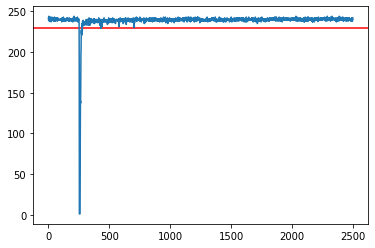

In [10]:
i = 14

print(errors[i])

chain.GetEntry(errors[i][0])

plt.axhline(y=height, color='red', linestyle='-')

plt.plot( waveform_in_units[:] )

In [11]:
len(peaks_x_coordinate)

5403

In [12]:
time_diff = []

for i in range(len(peaks_x_coordinate)):
    
    time_diff.append(   peaks_x_coordinate[i][1] - peaks_x_coordinate[i][0]   )

time_diff = pd.DataFrame(time_diff, columns=['delta_t'])

<AxesSubplot:ylabel='Count'>

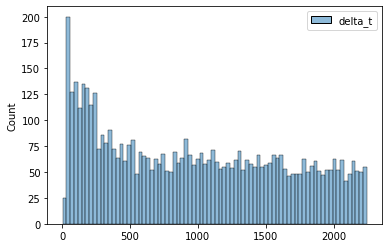

In [13]:
sns.histplot(time_diff, bins=80)

In [92]:
hist, bin_edges = np.histogram(time_diff, bins=45)

bin_diff     = bin_edges[1] - bin_edges[0]

bins_centers = [   (bin_edges[i] + bin_diff/2) for i in range (len(hist)) ]


In [133]:
xdata = [ Convert_TimeToMicroSec(bins, df_output['horizontal_main_scale'][0]) for bins in (bins_centers[:]) ]

ydata = hist[:]

In [96]:
popt, pcov = curve_fit(A_ExpX_C, xdata, ydata, p0=[100, 2, 5])

In [97]:
print(f'Coeficientes:\n{popt}\n\n')

print(f'Covariancia:\n{pcov}')

Coeficientes:
[153.67866779   1.33730695  97.41364538]


Covariancia:
[[ 1.72804228e+02 -1.52193642e+00  3.73173633e-01]
 [-1.52193642e+00  4.34678854e-02 -5.13869232e-01]
 [ 3.73173633e-01 -5.13869232e-01  1.47920434e+01]]


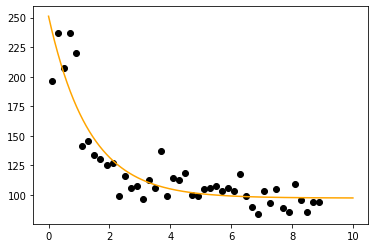

In [98]:
plt.scatter(xdata, ydata, color='black')

x = np.linspace(0, 10, 100_000)

y = A_ExpX_C(x, *popt)

plt.plot(x, y, color='orange')